[*********************100%***********************]  1 of 1 completed


🧠 Обучение Autoencoder...
AE Эпоха 1, Loss: 0.3934
AE Эпоха 2, Loss: 0.0415
AE Эпоха 3, Loss: 0.0292
AE Эпоха 4, Loss: 0.0267
AE Эпоха 5, Loss: 0.0236
AE Эпоха 6, Loss: 0.0276
AE Эпоха 7, Loss: 0.1400
AE Эпоха 8, Loss: 0.0761
AE Эпоха 9, Loss: 0.0297
AE Эпоха 10, Loss: 0.0214
AE Эпоха 11, Loss: 0.0246
AE Эпоха 12, Loss: 0.0210
AE Эпоха 13, Loss: 0.0260
AE Эпоха 14, Loss: 0.0191
AE Эпоха 15, Loss: 0.0225
AE Эпоха 16, Loss: 0.0181
AE Эпоха 17, Loss: 0.0225
AE Эпоха 18, Loss: 0.0167
AE Эпоха 19, Loss: 0.0171
AE Эпоха 20, Loss: 0.0166
🧠 Обучение LSTM...
LSTM Эпоха 1, Loss: 0.0591
LSTM Эпоха 2, Loss: 0.0199
LSTM Эпоха 3, Loss: 0.0176
LSTM Эпоха 4, Loss: 0.0175
LSTM Эпоха 5, Loss: 0.0181
LSTM Эпоха 6, Loss: 0.0156
LSTM Эпоха 7, Loss: 0.0155
LSTM Эпоха 8, Loss: 0.0159
LSTM Эпоха 9, Loss: 0.0158
LSTM Эпоха 10, Loss: 0.0154
LSTM Эпоха 11, Loss: 0.0154
LSTM Эпоха 12, Loss: 0.0163
LSTM Эпоха 13, Loss: 0.0155
LSTM Эпоха 14, Loss: 0.0153
LSTM Эпоха 15, Loss: 0.0154
LSTM Эпоха 16, Loss: 0.0156
LSTM 

<ipython-input-8-4391806aee08>:158: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


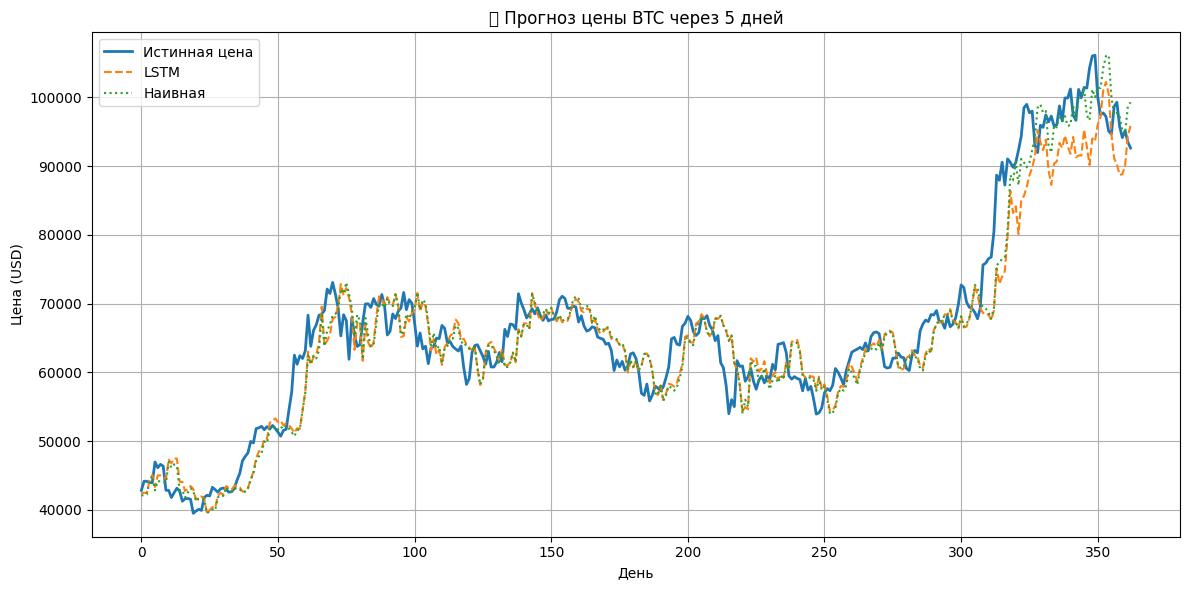

<ipython-input-8-4391806aee08>:169: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


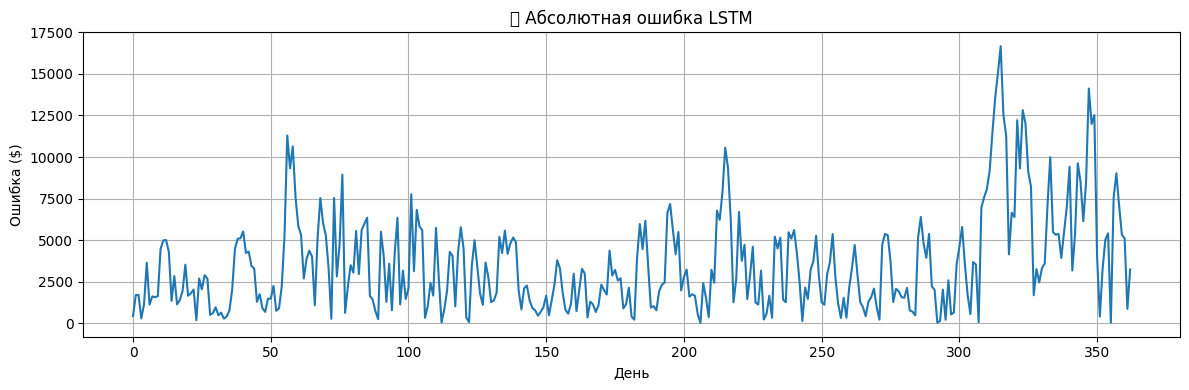

Object `скажешь` not found.


In [8]:
# !pip install yfinance torch matplotlib scikit-learn

import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader

# ⚙️ Настройки
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_SIZE = 64
EPOCHS_AE = 20
EPOCHS_LSTM = 20
BATCH_SIZE = 32
LR = 1e-3
WINDOW_SIZE = 10
PRED_OFFSET = 5

# 📥 Загрузка и нормализация
data = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31")[["Open", "High", "Low", "Close", "Volume"]].dropna()
target = data["Close"].values
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(data)
y_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(DEVICE)

# 🧱 Улучшенный автоэнкодер
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, LATENT_SIZE)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_SIZE, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 5)
        )
    def forward(self, z): return self.net(z)

encoder, decoder = Encoder().to(DEVICE), Decoder().to(DEVICE)
ae_optim = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)
ae_loss = nn.MSELoss()
loader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

# 🔧 Обучение AE
print("🧠 Обучение Autoencoder...")
for epoch in range(EPOCHS_AE):
    encoder.train(); decoder.train(); epoch_loss = 0
    for (batch,) in loader:
        z = encoder(batch)
        recon = decoder(z)
        loss = ae_loss(recon, batch)
        ae_optim.zero_grad(); loss.backward(); ae_optim.step()
        epoch_loss += loss.item()
    print(f"AE Эпоха {epoch+1}, Loss: {epoch_loss / len(loader):.4f}")

# 📦 Latent-признаки
encoder.eval()
with torch.no_grad():
    latent = encoder(X_tensor).cpu().numpy()

# 🔁 Последовательности и Δ-цели
def create_seq(X, y, win=10, offset=5):
    X_seq, y_seq, base_prices = [], [], []
    for i in range(len(X) - win - offset):
        X_seq.append(X[i:i+win])
        base = y[i+win]
        target = y[i + win + offset] - base
        y_seq.append(target)
        base_prices.append(base)
    return np.array(X_seq), np.array(y_seq), np.array(base_prices)

X_seq, y_seq, base_seq = create_seq(latent, y_scaled, WINDOW_SIZE, PRED_OFFSET)
split = int(len(X_seq)*0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
base_test = base_seq[split:]

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 🧠 LSTM с BatchNorm
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(LATENT_SIZE, 64, batch_first=True, dropout=0.3, num_layers=2)
        self.norm = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        normed = self.norm(last)
        return self.fc(normed)

model = LSTM().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

# 🔧 Обучение LSTM
print("🧠 Обучение LSTM...")
for epoch in range(EPOCHS_LSTM):
    model.train(); epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        epoch_loss += loss.item()
    print(f"LSTM Эпоха {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

# 📈 Предсказания и восстановление абсолютных цен
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(DEVICE)).cpu().numpy().flatten()
    y_true = y_test.cpu().numpy().flatten()

y_pred_rescaled = scaler_y.inverse_transform((y_pred + base_test).reshape(-1, 1)).flatten()
y_true_rescaled = scaler_y.inverse_transform((y_true + base_test).reshape(-1, 1)).flatten()
baseline_pred = target[len(target) - len(y_true_rescaled) - PRED_OFFSET:-PRED_OFFSET]

# 📊 Метрики
mse = mean_squared_error(y_true_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
mse_bl = mean_squared_error(y_true_rescaled, baseline_pred)
mae_bl = mean_absolute_error(y_true_rescaled, baseline_pred)

print(f"\n📈 LSTM:")
print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"\n🧱 Наивная модель:")
print(f"  MSE: {mse_bl:.2f}")
print(f"  MAE: {mae_bl:.2f}")

# 📉 График предсказаний
plt.figure(figsize=(12,6))
plt.plot(y_true_rescaled, label="Истинная цена", linewidth=2)
plt.plot(y_pred_rescaled, label="LSTM", linestyle="--")
plt.plot(baseline_pred, label="Наивная", linestyle=":")
plt.title("📈 Прогноз цены BTC через 5 дней")
plt.xlabel("День")
plt.ylabel("Цена (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Абсолютная ошибка
abs_error = np.abs(y_true_rescaled - y_pred_rescaled)
plt.figure(figsize=(12, 4))
plt.plot(abs_error)
plt.title("📉 Абсолютная ошибка LSTM")
plt.xlabel("День")
plt.ylabel("Ошибка ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


что скажешь?